In [95]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt
import random
import math
import statistics
from tqdm.auto import tqdm

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [5]:
#steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")

raw_data = np.load("/Users/michaelwrana/Documents/GLUE/data/dataset/awf/NoDef.npz")
raw_labels = raw_data['labels']
raw_traces = raw_data['traces']

In [6]:
trace_ids = list(set(raw_labels))

In [166]:
'''
Convert a raw packet trace into a processed version
trace: 1-D numpy array containing a packet trace
mode:
    'f': flatten the trace using packet arrival time
    'p': only include positive
    'n': only include negative
    'z': only remove zeroes
granularity: in 'f' mode, the smallest distance between packet arrival times to be considered
remove_zeroes: remove any zero values from the packet trace before processing (excluding z mode)
maxlen: reshape input list to be this length after processing by padding with 0
'''
def process(trace, mode='f', granularity=0.01, remove_zeroes=True, maxlen=10000):
    if remove_zeroes:
        trace = trace[trace != 0]
    
    if mode == 'f':
        processed_trace = []
        for i,x in enumerate(trace):
            distance = abs(x) - abs(trace[i-1])
            num_zeroes = math.ceil(distance/granularity)
            processed_trace += [0] * num_zeroes
            processed_trace.append(np.sign(x))
        return processed_trace + [0.0] * (maxlen - len(processed_trace))
    elif mode == 'p':
        return trace[trace >= 0]
    elif mode == 'n':
        return trace[trace <= 0]
    elif mode == 'z':
        return trace[trace != 0]
    else:
        raise TypeError("mode must be one of: f,p,n,z")

In [167]:
traces = {id: [None] * 4500 for id in trace_ids}
indices = {id: 0 for id in trace_ids}

In [168]:
#print(raw_traces[345][0:20])
#print(len(raw_traces[345]))
#test = process(raw_traces[345], mode='f', granularity=0.01, remove_zeroes=True)
#print(len(test))
#print(test[9950:])

In [169]:
# dictionary of all the traces as 2D numpy arrays
# keeping track of index for each one and setting value is necessary
# simple append is way too slow (>30 mins runtime)

for i in tqdm(range(len(raw_traces))):
    processed_trace = process(raw_traces[i], mode='z', remove_zeroes=True)
    
    traces[raw_labels[i]][indices[raw_labels[i]]] = processed_trace
    indices[raw_labels[i]] += 1

  0%|          | 0/450000 [00:00<?, ?it/s]

In [170]:
# print(len(traces))
# print(len(traces[0]))
# print(len(traces[45]))
# print(len(traces[0][0]))
# print(len(traces[45][50]))

In [226]:
# def get_sample_index(trace_list, mode):
#     for i in range(len(trace_list)):
#         if len(trace_list[i]) == mode:
#             return i

def generate_primary_sample(trace_list, mode='mode_avg'):
    
    if mode == "mode_avg":
        # get the mode trace length
        mode = statistics.mode([len(trace) for trace in primary_trace])
        # get a list of all traces of mode length
        mode_traces = np.asarray([trace for trace in primary_trace if len(trace) == mode])
        # return vertical average of traces
        return np.mean(mode_traces, axis=0)
    elif mode == 'mode_single':
        mode = statistics.mode([len(trace) for trace in primary_trace])
        for trace in trace_list:
            if len(trace) == mode:
                return trace
        
def calculate_scores(primary_sample, other_trace_list, sample_size=200, subseq_len=250):
    
    # create empty scores array
    trace_scores = [None] * sample_size
    primary_length = len(primary_sample)
    
    for i in range(sample_size):
        # collect single sample from comparison trace
        other_trace_sample = random.choice(other_trace_list).astype('float64')
        
        # compute distance between other trace and the primary sample
        trace_scores[i] = stumpy.gpu_mpdist(
        primary_sample,
        other_trace_sample,
        min(subseq_len, primary_length, len(other_trace_sample)),
        percentage=0.5,
        normalize=False
        )
    
    return trace_scores

In [227]:
# TRAINING MODE

final_scores = np.zeros((100,100))


for i in tqdm(range(100)):
    primary_trace = traces[i]
    primary_sample_set = random.sample(primary_trace, 10)
    
    
    #primary_trace_score = calculate_scores(primary_sample, primary_trace)
    #final_scores[i][0] = statistics.mean(primary_trace_score)
    
    for j in range(100):
        other_trace = traces[j]
        
        scores = [None] * len(primary_sample_set)
        for k in range(len(primary_sample_set)):
            score = calculate_scores(primary_sample_set[k].astype('float64'), other_trace, sample_size=10)
            mean_score = statistics.mean(score)
            scores[k] = mean_score
        
        final_scores[i][j] = statistics.mean(scores)

  0%|          | 0/100 [00:00<?, ?it/s]

Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.
Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.
Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.
Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.


In [183]:
'''
final_scores = np.zeros((100,100))


for i in tqdm(range(100)):
    primary_trace = traces[i]
    primary_sample = generate_primary_sample(primary_trace, mode="mode_avg")
    
    
    #primary_trace_score = calculate_scores(primary_sample, primary_trace)
    #final_scores[i][0] = statistics.mean(primary_trace_score)
    
    for j in range(100):
        other_trace = traces[j]
        scores = calculate_scores(primary_sample.astype('float64'), other_trace, sample_size=200)
        final_scores[i][j] = statistics.mean(scores)
'''

'\nfinal_scores = np.zeros((100,100))\n\n\nfor i in tqdm(range(100)):\n    primary_trace = traces[i]\n    primary_sample = generate_primary_sample(primary_trace, mode="mode_avg")\n    \n    \n    #primary_trace_score = calculate_scores(primary_sample, primary_trace)\n    #final_scores[i][0] = statistics.mean(primary_trace_score)\n    \n    for j in range(100):\n        other_trace = traces[j]\n        scores = calculate_scores(primary_sample.astype(\'float64\'), other_trace, sample_size=200)\n        final_scores[i][j] = statistics.mean(scores)\n'

In [229]:
print(final_scores[71][0])

261.16373727388066


In [230]:
correct_count = 0
incorrect_count = 0

i=0

for i in range(100):
    base_score = final_scores[i][i]

    sample_i_correct = 0
    for j in range(100):
        if final_scores[i][j] > base_score:
            correct_count += 1
            sample_i_correct += 1
        else:
            incorrect_count += 1
    
    #print("Sample " + str(i) + " correct:" + str(sample_i_correct))
        
print("Correct: " + str(correct_count))
print("Incorrect: " + str(incorrect_count))

print("Correct (%): " + str(correct_count/(incorrect_count + correct_count) * 100))

Correct: 5749
Incorrect: 4251
Correct (%): 57.489999999999995


In [222]:
# CLASSIFIER MODE

num_tests = 1
num_classes = 100

for i in range(num_tests):
    class_id, trace_list = random.sample(list(traces.items()), 1)[0]
    
    print("Class ID: " + str(class_id))
    
    trace = np.asarray(random.sample(trace_list, 1)[0]).astype('float64')
    
    scores = [None] * num_classes
    
    for i in range(num_classes):
        
        score = statistics.mean(calculate_scores(trace, traces[i], sample_size=100))
        
        scores[i] = score
    

Class ID: 70


In [223]:
min_vals = sorted(range(len(scores)), key=lambda k: scores[k])

print(min_vals[:3])


for val in min_vals[:3]:
    print("Value: " + str(val) + "Score: " + str(scores[val]))

[61, 75, 27]
Value: 61Score: 4.598227140841204
Value: 75Score: 4.613111578267043
Value: 27Score: 5.10539306276152


In [225]:
print(min_vals[0])
print(scores[min_vals[99]])

61
20.288245858071942


In [165]:
'''
results

    mode:p, mode:mode_single, sample size:250, subsequence length: 100
    Correct 6880/10000
    
    mode:n, mode:mode_single, sample size:250, subsequence length: 100
    Correct 6771/10000
    
    mode:z, mode:mode_single, sample size:250, subsequence length: 100
    Correct 7073/10000
    
    mode:p, mode:mode_avg, sample size:250, subsequence length: 100
    Correct 5811/10000
    
    mode:n, mode:mode_avg, sample size:250, subsequence length: 100
    Correct 5591/10000
    
    mode:z, mode:mode_avg, sample size:250, subsequence length: 200
    Correct 6480/10000

    
    mode:z, mode:combine_samples, sample size:20, subsequence length: 250
    Correct 7189/10000
    
    
NOTES:
    This parameter on its own is not sufficient to do n-class classification
        -> combine with other parameters (e.g. k-fp) and see if it improves?
        -> return to original problem and methods to attempt to see
        if we can actually identify the beginning/end of fingerprints
    
'''



with open('final_score2s.npy', 'wb') as f:
    np.save(f, final_scores)

In [59]:
print(final_scores)

[[1.03562197 1.10579048 4.391445   ... 1.53329876 1.61927396 1.32039777]
 [1.05730949 1.47517159 5.51761252 ... 0.93081099 1.73236581 1.13853428]
 [4.51918209 4.66336293 4.95641515 ... 5.59425164 1.67595743 4.56882635]
 ...
 [0.88720507 1.57537022 5.98422112 ... 0.49731865 1.91384793 1.00191308]
 [1.38345155 1.42961688 1.28886238 ... 1.56937689 1.86744693 1.40129088]
 [0.95295248 1.44230067 5.06445302 ... 0.73094705 1.58176509 0.996868  ]]


Correct: 98
Incorrect: 2
Correct (%): 98.0


In [22]:
print(final_scores[0][0])

1.0356219710424235


In [43]:
print(final_scores[0][0])

1.0256548760968376

In [45]:
trace_scores = {id: [None] for id in trace_ids}

for id in tqdm(trace_ids):
    other_trace = traces[id]
    other_trace_score = [0] * 4500
    for i in range(1, len(other_trace)):
        other_trace_score[i] = stumpy.mpdist(
            np.asarray(primary_sample).astype("float64"), 
            np.asarray(other_trace[i]).astype("float64"),
            min(100,len(other_trace[i]))
        )
    trace_scores[id] = other_trace_score

  0%|                                                   | 0/100 [00:00<?, ?it/s]Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.
Arrays T_A, T_B are equal, which implies a self-join.
Try setting `ignore_trivial = True`.
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.
100%|█████████████████████████████████████████| 100/100 [17:10<00:00, 10.30s/it]


In [53]:
correct_count = 0
incorrect_count = 0
base_score = statistics.mean(primary_trace_score)
for id in trace_ids:
    if statistics.mean(trace_scores[id]) > base_score:
        correct_count += 1
    else:
        incorrect_count += 1
        
print("Correct: " + str(correct_count))
print("Incorrect: " + str(incorrect_count))

Correct: 92
Incorrect: 8


In [33]:
i=500
j=1
trace1_nonzero = trace1[i][trace1[i] != 0]
trace2_nonzero = trace2[j][trace2[j] != 0]

stumpy.mpdist(trace1_nonzero, trace2_nonzero, 50)

4.408205660526596

In [10]:
print(trace1.shape)
print(trace2.shape)

# flatten them
trace1 = trace1.flatten()
trace2 = trace2.flatten()

print(trace1.shape)
print(trace2.shape)

trace1 = trace1[trace1 != 0]
trace2 = trace2[trace2 != 0]

print(trace1.shape)
print(trace2.shape)


(4500, 5000)
(4500, 5000)
(22500000,)
(22500000,)
(11518285,)
(17513090,)


In [ ]:
stumpy.gpu_mpdist(trace1, trace2, 2500)

In [ ]:
stumpy.mpdist(trace1, trace2, 2500)

In [3]:
# get max_traces packet traces from IDs in id_list

# number of traces to extract per ID
max_traces = 4

# array of trace IDs to extract
id_list = [66]

# row: list of arrays for trace 
# index: 
traces = {trace_id : [] for trace_id in id_list}

for trace_id in id_list:
    trace = []
    i = 0
    found_traces = 0
    
    # faster cause dataset is massive and takes forever to load - normally not neeeded
    # get 2 examples of data with class trace_id and save them into traces array
    while(found_traces < max_traces):
        if(raw_labels[i] == trace_id):
            print("Found trace with id: " + str(trace_id) + " at index: " + str(i))
            
            # list comprehension to remove 0s
            
            trace.append([0] + [x for x in raw_traces[i] if x != 0 and x > 0] + [0] * 150)
            
            # or just pass directly
            #trace.append(raw_traces[i])
            
            found_traces += 1

        i += 1
        
    traces[trace_id] = trace

Found trace with id: 66 at index: 102
Found trace with id: 66 at index: 145
Found trace with id: 66 at index: 265
Found trace with id: 66 at index: 335


In [4]:
print(len(traces[66]))

4


In [5]:
# collect random traces and create a combined trace

combined_trace = traces[id_list[0]]

num_random_traces = 6

for i in range(num_random_traces):
    combined_trace.append([0] + [x for x in  random.choice(raw_traces) if x != 0 and x > 0] + [0] * 150)

# flatten and convert to numpy

combined_trace = np.asarray([item for sublist in combined_trace for item in sublist])

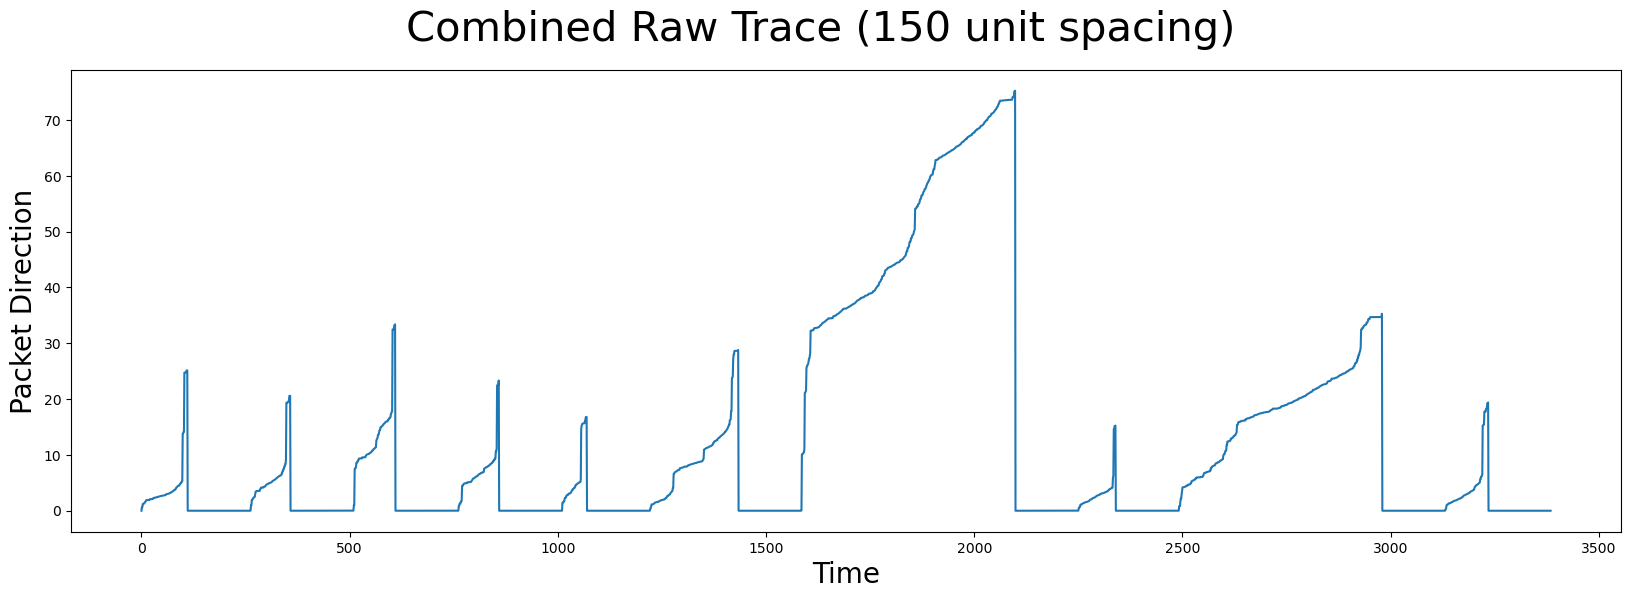

In [6]:
plt.suptitle('Combined Raw Trace (incoming packets only)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Packet Direction', fontsize='20')
plt.plot(combined_trace)
plt.show()

In [12]:
# query matching string
Q = np.array(combined_trace[0:160]).astype(np.float64)

matched_array = stumpy.match(Q,combined_trace,max_distance=np.inf,max_matches=8)

In [13]:
print(matched_array)

[[1.066240299940009e-06 0]
 [4.3640112627042695 3124]
 [4.399558091407931 247]
 [5.454403996808169 959]
 [6.133917446609134 2229]
 [7.1350660863618325 748]
 [7.288806758829353 499]
 [7.812909415665595 1323]]


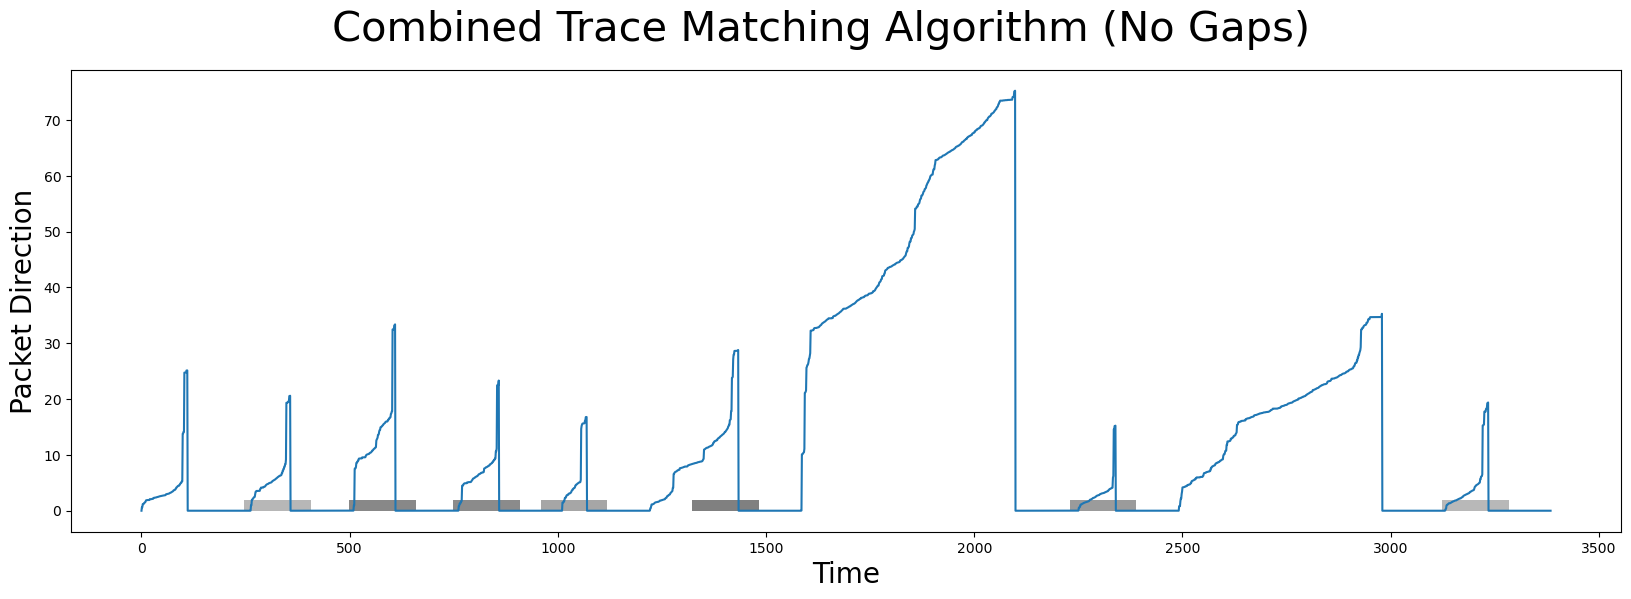

In [14]:
plt.suptitle('Combined Trace Matching Algorithm (No Gaps)', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Packet Direction', fontsize='20')
ax = plt.gca()

# (x - xminimum) / range
min_score = 10000
max_score = 0

for match in matched_array:
    if match[0] > max_score:
        max_score = match[0]
    if match[0] < min_score:
        min_score = match[0]

for match in matched_array:
    match [0] = (match[0]-min_score)/(max_score - min_score)

for match in matched_array:
    rect = Rectangle((match[1],0),len(Q),2,facecolor='gray',alpha=match[0])
    ax.add_patch(rect)
    
plt.plot(combined_trace)

In [15]:
processed_trace = np.asarray(processed_trace)

m = 1200
mp = stumpy.stump(processed_trace.astype(np.float64), m)

In [144]:
motif_idx = np.argsort(mp[:, 0])[0]

print(f"The motif is located at index {motif_idx}")

The motif is located at index 23825


In [145]:
nearest_neighbor_idx = mp[motif_idx, 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 26942


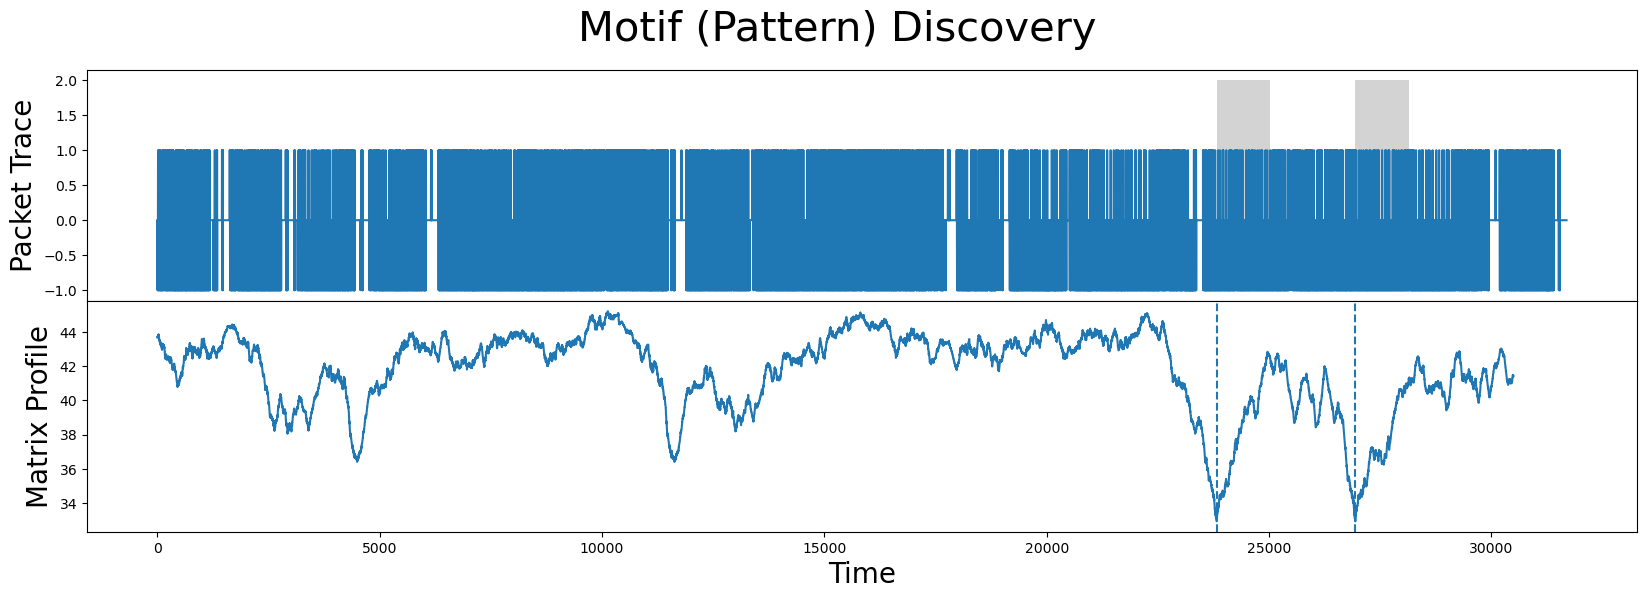

In [148]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='30')

axs[0].plot(processed_trace)
axs[0].set_ylabel('Packet Trace', fontsize='20')
rect = Rectangle((motif_idx, 0), m, 2, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 2, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()